# Import Model

Import diatom analysis framework from scripts. Diatom model must be located in the "models" directory. Flux balance analysis and flux variability analysis are performed using Gurobi by default.

In [ ]:
from src import Diatom

diatom = Diatom("iLB1027_lipid.xml", model_name="P. Tricornutum", solver="gurobi")

diatom.model.solver.problem.Params.Threads = 14
diatom.model.solver.configuration.log_output = True
diatom.model.solver.problem.Params.LogToConsole = 1
diatom.model

'R_AAL(fum)_c' is not a valid SBML 'SId'.
'R_sink_Asn-X-Ser_Thr_c' is not a valid SBML 'SId'.


In [ ]:
# METABOLITES 
diatom.add_metabolite('ci_e', formula='Ci', name='Inorganic Carbon', compartment='e')

# REACTIONS
reactions = {
    "EX_ci_e": {"ci_e": -1.0}, # inorganic carbon uptake
    "CI_CO2_e": {"ci_e": -1.0, "co2_e": 1.0}, # ci to co2 conversion
    "CI_HCO3_e": {"ci_e": -1.0, "hco3_e": 1.0}, # ci to hco3 conversion
}
diatom.add_reactions(reactions)

# BOUND CONSTRAINTS
CI_UPTAKE = -25.0
bound_constraints = {
    "EX_photon_e": (-100, 0),
    "EX_no3_e": (-2, 0),
    "EX_nh4_e": (-0.0, 0),
    "EX_co2_e": (0, 0),
    "EX_hco3_e": (0, 0),
    "EX_ci_e": (CI_UPTAKE, 0),
}
diatom.modify_bounds(bound_constraints)

# FLUX CONSTRAINTS
alpha = 0.1

# v_co2 + alpha * v_ci >= 0
diatom.add_flux_constraint(
    {"CI_CO2_e": 1.0, "EX_ci_e": alpha}, 
    ub=0, 
    name="CI_CO2_coupling",
)

# v_hco3 + (1 - alpha) * v_ci >= 0
diatom.add_flux_constraint(
    {"CI_HCO3_e": 1.0, "EX_ci_e": 1-alpha}, 
    ub=0, 
    name="CI_HCO3_coupling",
)

In [ ]:
from cobra.flux_analysis.parsimonious import pfba
pfba(diatom.model)

,fluxes,reduced_costs
ATPS_m,24.946147,-2.0
IDP_h,0.147100,-2.0
IDP_m,0.000000,-2.0
THD2_m,0.000000,16.0
ATAM_c,1.187382,-2.0
...,...,...
AGPATCOA_LNA_LNA_c,0.000000,-2.0
CHOPT_LNA_LNA_c,0.000000,238.0
EX_ci_e,-8.599392,2.0
CI_CO2_e,4.299696,-2.0


In [ ]:
reaction_tuple = ("EX_ci_e", "DM_biomass_c")

diatom.set_sampling_instance(
    reaction_tuple=reaction_tuple,
    grid_delta=0.02,
    n_clusters=12,
    use_pfba=True,
    save_files=True,
    load_files=True,
)

Maximize
1.0*DM_biomass_c - 1.0*DM_biomass_c_reverse_c49c1 

Generated hash 'n_const=6_#59ce2f1124614d78' for current sampling metadata:
model_filename: iLB1027_lipid.xml
model_hash: 155cc3eaf6eb7fe6105855961f4db75bfc66cf72e1b3ac04e205b9dda9121587
reaction_tuple: ['EX_ci_e', 'DM_biomass_c']
bound_constraints: {'EX_ci_e': [-25.0, 0], 'EX_co2_e': [0, 0], 'EX_hco3_e': [0, 0], 'EX_nh4_e': [-0.0, 0], 'EX_no3_e': [-2, 0], 'EX_photon_e': [-100, 0]}
n_bound_constraints: 6
metabolites: [{'metabolite_id': 'ci_e', 'formula': 'Ci', 'name': 'Inorganic Carbon', 'compartment': 'e'}]
reactions: [{'EX_ci_e': {'ci_e': -1.0}, 'CI_CO2_e': {'ci_e': -1.0, 'co2_e': 1.0}, 'CI_HCO3_e': {'ci_e': -1.0, 'hco3_e': 1.0}}]
flux_constraints: [{'expression': {'CI_CO2_e': 1.0, 'EX_ci_e': 0.5}, 'ub': 0, 'name': 'CI_CO2_coupling'}, {'expression': {'CI_HCO3_e': 1.0, 'EX_ci_e': 0.5}, 'ub': 0, 'name': 'CI_HCO3_coupling'}]
use_pfba: True
pfba_fraction_of_optimum: 1.0

Data generated during analysis will not be stored.

No da

## Polytope Sampling



In [ ]:
def polytope_pipeline(n_clusters: int, **kwargs):
    """Pipeline used to sample the feasible polytope projection for the given reaction tuple. 

    Parameters
    ----------
    reactions : tuple[str, str]
        Reaction tuple set for analysis. The first reaction will act as the independent axis, the second
        reaction will be set to the reaction to maximize, acting as the dependent axis.

    n_angles: int
        Number of angles specified for defining the projection polytope using ... method.

    delta: float
        Grid spacing used to generate the regular sampling grid. Corresponds to a fraction of
        the polytope bounding box size. (eg. delta=0.1 will generate steps whose lengths are 
        10% of the total length of each axis.)
       
    n_clusters: int
        Number of clusters to be generated. 

    Notes
    -----
    Smaller delta values will lead to denser sampling at higher computational cost. 

    """
    diatom.projection.project_polytope_2d()
    diatom.grid.sample_polytope()
    diatom.plot.polytope_shape(**kwargs) # optional
    diatom.analyze.qualitative_analysis(only_load=False)
    diatom.clustering.set_grid_clusters('hierarchical', k = n_clusters)
    diatom.plot.sampled_polytope(show_boundary=True, **kwargs) # optional

Number of iterations: 0


/home/chuckolate/ecosystem/src/diatom/plot.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


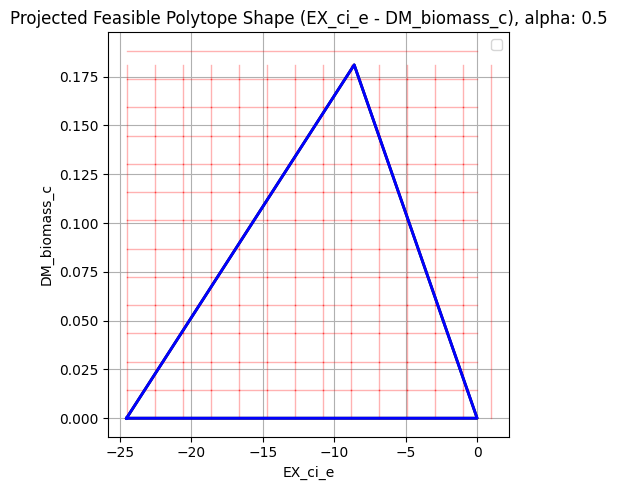

Running qualitative fva over grid feasible points...
No reactions previously selected for FVA and clustering!
Setting reactions for analysis...

Analyzing point feasibility....


  1%|          | 1/124 [00:15<31:43, 15.47s/it]

KeyboardInterrupt: 

In [ ]:
polytope_pipeline(n_clusters=10, alpha=alpha)


## Cluster Analysis

In [ ]:
def clustering_pipeline(reaction_list, threshold=0.8, changing=False, overwrite=False):
    print("Qualitative Profiles "+"="*80+"\n")
    qualitative_profiles = diatom.clustering.get_grid_cluster_qual_profiles(threshold=threshold, changing=changing, selected_reactions=reaction_list, overwrite=overwrite)
    display(qualitative_profiles)

    print("Per Reaction Metrics "+"="*80+"\n")
    metrics_per_reaction = diatom.clustering.get_cluster_metrics_per_reaction(reaction_list, overwrite=overwrite)
    display(metrics_per_reaction)

    print("Global Metrics "+"="*80+"\n")
    global_metrics = diatom.clustering.get_cluster_global_metrics(reaction_list, overwrite=overwrite)
    display(global_metrics)

    diatom.io.merge_to_excel({"qualitative profiles": qualitative_profiles, "per reaction metrics": metrics_per_reaction, "global metrics": global_metrics})


In [ ]:
df, reaction_list = diatom.clustering.reaction_scores(sort_score = True, sort_index = 5, show = True)

                          votes   mean_rank
LEUt_h                        5  281.666667
4MOPt_h                       5  282.000000
BCTAL_h                       5  283.833333
GLUDH_c                       4   58.166667
ILEt_h                        4  296.000000
3MOPt_h                       4  296.333333
FAC1619Zt_c                   4  422.083333
ASPNA1t_h                     4  474.333333
GLUNA1t_h                     4  482.500000
NAHt_h                        3  115.666667
CA_m                          3  152.333333
MTHFO2_c                      3  238.500000
MTHFO1_c                      3  249.166667
BCTAI_h                       3  302.166667
DHFR2_c                       3  401.333333
TAGAH_OLE_HDE_OLE_c           3  440.750000
AKGMALt_h                     3  485.750000
ASPTA_L_h                     3  510.833333
ORNC_c                        2   64.500000
ENO_m                         2   74.333333
NH4t_h                        2   92.500000
EX_h2o_e                      2 

In [ ]:
REACTIONS = [
    # BIOMASS
    "DM_biomass_c",
    
    # EXCHANGE
    "EX_co2_e",
    "EX_o2_e",
    "EX_h2o_e",
    "EX_co_e", 
    "EX_no3_e",
    "EX_photon_e",
    
    # CHLOROPLAST
    "ATPS_h",
    "ATPM_h",
    "GLNA_h",
    "GLTS_h",
    "ACCOAC_h",
    "ACOATA_h",
    "NTRIR_h",
    "PSII_u",
    "FNOR_h",
    "GDR_NADP_h",
    "RUBISO_h",
    "RUBISC_h", 
    "DXPS_h",
    "CA_h", # important for carbon fixing
    #"MEHLER_h",

    # MITOCHONDRIA
    "ATPS_m",
    "ATPM_m",
    "GLNA_m",
    "GLTS_m",
    "THD2_m",
    "GLUDH2_m",
    #"AGAS_m",

    # CYTOSOL
    "ATPS_c",
    "TAGAH_HDE_ARA_ARA_c",
    "ACOADAGAT_EPA_EPA_EPA_c",
    "ACOADAGAT_HDE_ARA_ARA_c",
    "NOR_c",
    "PAPA_EPA_EPA_c",
    "NITR_c",
    "HISD_c",
]

clustering_pipeline(reaction_list + ["ATPM_h", "PAPA_EPA_EPA_c", "CA_h"], overwrite=True)

Qualitative Profiles ================================================================================

cluster_dfs len: 10


,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
LEUt_h,0,0,++,0,0,-0,-0,0+,0+,0+
4MOPt_h,0,0,++,0,0,-0,-0,0+,0+,0+
BCTAL_h,0,0,--,0,0,0+,0+,-0,-0,-0
GLUDH_c,0,0,+,-,-,+,-,+,+,++
ILEt_h,0,0,++,NaN,NaN,-0,-0,++,++,++
3MOPt_h,0,0,0+,NaN,NaN,--,--,0+,0+,0+
FAC1619Zt_c,0,0,+,+,0+,0+,0+,0,0+,0+
ASPNA1t_h,0,0,NaN,NaN,++,NaN,-,-0,-0,++
GLUNA1t_h,0,0,NaN,NaN,-0,NaN,-,++,++,-0
NAHt_h,+,-,-,-,NaN,--,NaN,+,NaN,0


Per Reaction Metrics ================================================================================



,reaction_id,cluster,metric,value
0,LEUt_h,1,minimum,-1.372413e-11
1,LEUt_h,1,maximum,2.453165e+01
2,LEUt_h,1,mean_range,4.088608e+00
3,LEUt_h,1,mean_midpoint,2.044304e+00
4,LEUt_h,1,mean_relative_range,1.647885e-01
...,...,...,...,...
6155,CA_h,10,frac_zero_fixed,0.000000e+00
6156,CA_h,10,frac_bidirectional,0.000000e+00
6157,CA_h,10,mean_abs_flux,6.249916e+00
6158,CA_h,10,std_range,0.000000e+00


Global Metrics ================================================================================



ValueError: Reaction 'EX_no3_e' not found in fva_reactions

In [ ]:
"""
grid_x = [-50, -100, -150, -175]
grid_y = [0.3, 0.2, 0.1]

reaction_couplings = [
    ('EX_co2_e', 'RUBISC_h'),
    ('EX_o2_e', 'RUBISO_h'),
    ("RUBISC_h", "RUBISO_h"),
    ("EX_no3_e", "NTRIR_h")
]

for coupling in reaction_couplings:
    diatom.analyze.quan_FCA(grid_x, grid_y, coupling)
    diatom.plot.plot_qFCA()
"""